<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [3]:
!pip install torchgeo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [161]:
###############################################################################
# Imports
###############################################################################
import torch
import torch.nn as nn
import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from pathlib import Path
import os
import time
import torchvision
import copy
import math

import tempfile
from torch.utils.data import DataLoader
from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"on device: {device}")

###############################################################################
# Hyperparameters
###############################################################################

batch_size = 1
size = 512 # size of patches
length = 500
eval_iterations = 100

cmap_dict = {0: (0, 0, 0, 0), 1: (0, 197, 255, 255), 2: (0, 168, 132, 255), 3: (38, 115, 0, 255), 4: (76, 230, 0, 255), 5: (163, 255, 115, 255), 6: (255, 170, 0, 255), 7: (255, 0, 0, 255), 8: (156, 156, 156, 255), 9: (0, 0, 0, 255), 10: (115, 115, 0, 255), 11: (230, 230, 0, 255), 12: (255, 255, 115, 255), 13: (197, 0, 255, 255)}


on device: cuda


## Helper functions

In [5]:
###############################################################################
# Helper Functions
###############################################################################
cmap_dict = {0: (0, 0, 0, 0), 1: (0, 197, 255, 255), 2: (0, 168, 132, 255), 3: (38, 115, 0, 255), 4: (76, 230, 0, 255), 5: (163, 255, 115, 255), 6: (255, 170, 0, 255), 7: (255, 0, 0, 255), 8: (156, 156, 156, 255), 9: (0, 0, 0, 255), 10: (115, 115, 0, 255), 11: (230, 230, 0, 255), 12: (255, 255, 115, 255), 13: (197, 0, 255, 255)}

def evaluate(model, dataloader):
  """ Evaluates model

  Parameters:
    model (torch.Module) -- model to train
    dataloader (torch.utils.data.DataLoader) --dataloader to test on
    eval_iterations (interval) --

  Returns loss (float)
  """
  model.eval()
  with torch.inference_mode():
    losses = []
    for i, sample in enumerate(dataloader):
      if i< length-eval_iterations:
        continue
      image, target = sample["image"].to(device), sample["mask"].to(device)
      logits, loss = model(image, target)
      losses.append(loss.item())
  model.train()
  return round(np.array(losses).mean(), 5)
  
def display_output(model, image, target):
  """Displays a plt plot of the predictions

  Parameters:
    logits (torch.Tensor) --raw predictions from model
    target (torch.Tensor) --unformated target mask
    original_image (torch.Tensor) --original satellite image
  """

  image, target = image.to(device), target.to(device)
  model.eval()
  with torch.inference_mode():
    logits, loss = model(image, target)
    print("Loss:", loss)


  output = logits.permute(0, 2, 3, 1)
  output = nn.functional.softmax(output, dim=-1)
  output = torch.argmax(output, dim=-1)
  pred = output[0].detach().cpu().numpy()

  diff = 94 # (512 - 324)//2
  cropped_target = target[0, 0, diff:-diff, diff:-diff].detach().cpu().numpy()
  original_image = PIL.Image.fromarray(np.uint8(image[0, :, diff:-diff, diff:-diff].permute(1, 2, 0).detach().cpu().numpy())).convert("RGB")
  cmap_dict

  pred_converted = np.array([[cmap_dict[x] for x in row] for row in pred])
  crop_converted = np.array([[cmap_dict[x] for x in row] for row in cropped_target])
    
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(16, 10)
  ax1.set_title("Model Prediction")
  ax2.set_title("Real Labels")
  ax1.imshow(pred_converted)
  ax2.imshow(crop_converted)
  plt.show()

  fig, ax = plt.subplots(1, 1)
  fig.set_size_inches(8, 10)
  ax1.set_title("Original Image")
  ax.imshow(original_image)
  plt.show()

## Download data and creating Dataloaders

In [7]:
# From https://github.com/microsoft/torchgeo/blob/main/docs/tutorials/getting_started.ipynb
data_root = tempfile.gettempdir()
naip_root = os.path.join(data_root, "naip")
naip_url = (
    "https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
)
tiles = [
    "m_3807511_ne_18_060_20181104.tif",
    "m_3807511_se_18_060_20181104.tif",
    "m_3807512_nw_18_060_20180815.tif",
    "m_3807512_sw_18_060_20180815.tif",
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)
    
naip = NAIP(naip_root)
chesapeake_root = os.path.join(data_root, "chesapeake")
chesapeake = ChesapeakeDE(chesapeake_root, crs=naip.crs, res=naip.res, download=True)

  0%|          | 0/513332284 [00:00<?, ?it/s]

  0%|          | 0/521985441 [00:00<?, ?it/s]

  0%|          | 0/489865657 [00:00<?, ?it/s]

  0%|          | 0/484476647 [00:00<?, ?it/s]

  0%|          | 0/287350495 [00:00<?, ?it/s]

In [134]:
dataset = naip & chesapeake
sampler = RandomGeoSampler(dataset, size=size, length = length)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples, batch_size = batch_size)

torch.Size([1, 4, 512, 512]) torch.Size([1, 1, 512, 512])
Number of classes: 14


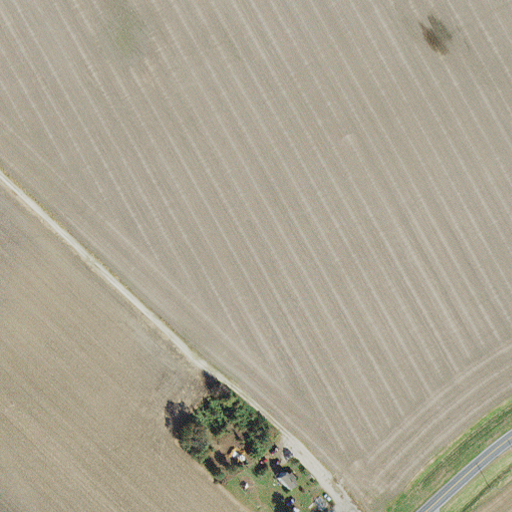

In [135]:
###############################################################################
# Exploratory data analysis
###############################################################################
# Displaying data we're working with
# I think the 4th dimension is cloud cover
sample = next(iter(dataloader))
image, target = sample["image"], sample["mask"]
print(image.shape, target.shape)
converted = np.array([[cmap_dict[x] for x in row] for row in target[0][0].numpy()])
num_classes = len(cmap_dict.keys())
print(f"Number of classes: {num_classes}")

PIL.Image.fromarray(np.uint8(image[0].permute(1, 2, 0).numpy())).convert("RGB")

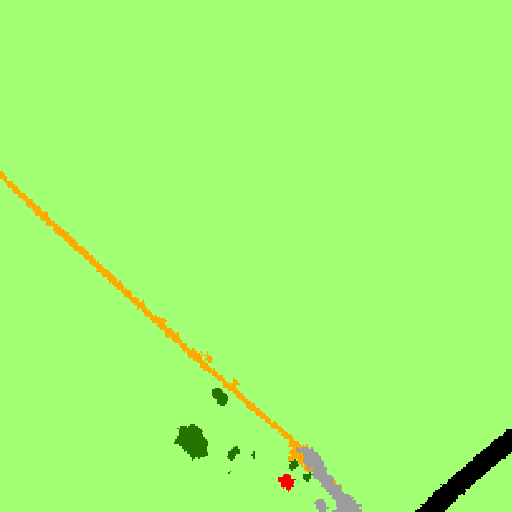

In [136]:
PIL.Image.fromarray(np.uint8(converted))

In [ ]:
# converted = np.array([[cmap_dict[x] for x in row] for row in target[0, 0, :324, :324].numpy()])
# PIL.Image.fromarray(np.uint8(converted))

## Models

In [13]:
#Delete when using kaggle
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [158]:
###############################################################################
# Models
###############################################################################
num_classes = 14

class DoubleConv(nn.Module):
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
      
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    conv1 = nn.Sequential(
        nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm2d(output_channels),
        nn.ReLU())

    conv2 = nn.Sequential(
        nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm2d(output_channels),
        nn.ReLU())
    
    nn.init.normal_(conv1.weight, mean=0.0, std= math.sqrt(2/(9*input_channels))) #sqrt(2/N)
    nn.init.normal_(conv2.weight, mean=0.0, std= math.sqrt(2/(9*output_channels)))
    self.conv = nn.Sequential(conv1, conv2)
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.conv(x)

class DownSampleBlock(nn.Module):
  """
  DownSampling block in UNET

  MaxPool, DoubleCov
  MaxPool, Conv, BatchNorm, ReLU, Conv, BatchNorm, ReLU
  """

  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.

    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.conv = DoubleConv(input_channels, output_channels)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.conv(self.max_pool(x))

class UpSampleBlock(nn.Module):
  """
  UpSampling block in UNET

  Upsample, Conv, Concat, Conv, ReLU, Conv, ReLU
  """

  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.up_sample = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2)
    self.conv = DoubleConv(input_channels, output_channels)

  def forward(self, x: torch.Tensor, res: torch.Tensor) -> torch.Tensor:
    """Forward pass for DownSampleBlock.

     Parameters:
      x (torch.Tensor) -- input tensor to block
      res (torch.Tensor) -- residual connection feeding into block
    
    Return x
    x will be used as the input to the next upsizing block (or final layer)
    """
    x = self.up_sample(x)
    size_diff1 = (res.shape[2]-x.shape[2])//2
    size_diff2 = (res.shape[2]-x.shape[2]) - size_diff1
    x = torch.concat((x, res[:, :, size_diff1:-size_diff2, size_diff1:-size_diff2]), dim = 1)
    x = self.conv(x)
    return x

class UNET(nn.Module):
  def __init__(self, channels_in = 4):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      channels_in (int) -- input images channel size
    """
    super().__init__()
    self.first_conv = DoubleConv(channels_in, 64)
    self.downsample_blocks = nn.ModuleList([DownSampleBlock(c, 2*c) for c in [64, 128, 256, 512]])
    self.upsample_blocks = nn.ModuleList([UpSampleBlock(2*c, c) for c in [512, 256, 128, 64]])
    self.final_layer = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
    self.loss_fn = nn.CrossEntropyLoss()
  
  def forward(self, x: torch.Tensor, target=None) -> torch.Tensor:
    """Forward pass for DownSampleBlock.

     Parameters:
      x (torch.Tensor) --input tensor to block
      targets (torch.Tensor) --target output of model

    Returns (logits, loss)

    logits (torch.Tensor) --model's raw output
    loss (torch.float32) --2d CrossEntropyLoss result
    """
    x = self.first_conv(x)
    residuals = []
    for downsample in self.downsample_blocks:
      residuals.append(x)
      x = downsample(x)
    for i, upsample in enumerate(self.upsample_blocks):
      x = upsample(x, residuals[-(i+1)])
    x = self.final_layer(x)

    if target is None:
      loss = None
    else:
      diff = 94 # (512 - 324)//2
      loss = self.loss_fn(x, target[:, 0, diff:-diff, diff:-diff])
    return x, loss


# def init_weights(m):
#   """Initialize model weights.
  
#   From paper:
#   "Ideally the initial weights should be adapted such that each
#   feature map in the network has approximately unit variance.
#   For a network with our architecture (alternating convolution and ReLU layers) this can be achieved
#   by drawing the initial weights from a Gaussian distribution with a standard deviation of sqrt(2/N)
#   where N denotes the number of incoming nodes of one neuron
#   E.g. for a 3x3 convolution and 64 feature channels in the previous layer N = 9 · 64 = 576."
#   """
#   if isinstance(m, nn.Linear):
#       torch.nn.init.xavier_uniform(m.weight)
#       m.bias.data.fill_(0.01)


model = UNET().to(device)
# model.apply(init_weights)
image, target = sample["image"].to(device), sample["mask"].to(device)
logits, loss = model(image, target)
print(logits.shape, loss)

torch.Size([1, 14, 324, 324]) tensor(2.8609, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


In [160]:
def train_loop(model, dataloader, epochs, learning_rate = 0.03, optimizer=None, scheduler=None, eval_interval=100):
  """ Trains model

  Parameters:
    model (torch.Module) --model to train
    train_dataloader (torch.utils.data.DataLoader) --dataloader to train on
    epochs (int) --iterations to loop through train_dataloader
    learning_rate (float) --lr passed to default optimizer
    optimizer (torch.optim) --optimizer to use during training
    scheduler (torch.optim.lr_scheduler) --scheduler used to modify lr during training
  """
  if optimizer is None:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  model.train()
  for epoch in range(epochs):
    running_loss = 0.
    epoch_train_loss = []
    test_losses = []
    for i, sample in enumerate(dataloader):
      image, target = sample["image"].to(device), sample["mask"].to(device)
      logits, loss = model(image, target)
      if i<=length-eval_iterations:
        #Train model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        epoch_train_loss.append(loss.item())
        if i%eval_interval==eval_interval-1:
          print(f"Running loss epoch {epoch}, i: {i} = {running_loss/eval_interval:.4f}")
          running_loss=0
        if scheduler is not None: scheduler.step()
      else:
        #Evaluate model
        model.eval()
        with torch.inference_mode():
            image, target = sample["image"].to(device), sample["mask"].to(device)
            logits, loss = model(image, target)
            test_losses.append(loss.item())
    
    print(f"Average train loss for epoch {epoch}: {np.array(epoch_train_loss).mean():.4f}")
    print(f"Test loss: {round(np.array(test_losses).mean(), 5)}")

learning_rate=3e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)#, weight_decay=0.99)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 200)
train_loop(model, dataloader, epochs=5, optimizer=optimizer)#, scheduler=scheduler)

Running loss epoch 0, i: 99 = 1.2912
Running loss epoch 0, i: 199 = 0.8859
Running loss epoch 0, i: 299 = 0.9262
Running loss epoch 0, i: 399 = 0.9166
Average train loss for epoch 0: 1.0040
Test loss: 0.73568
Running loss epoch 1, i: 99 = 1.0684
Running loss epoch 1, i: 199 = 0.7574
Running loss epoch 1, i: 299 = 0.7354
Running loss epoch 1, i: 399 = 0.6543
Average train loss for epoch 1: 0.8027
Test loss: 0.68275
Running loss epoch 2, i: 99 = 0.6693
Running loss epoch 2, i: 199 = 0.5447
Running loss epoch 2, i: 299 = 0.6801
Running loss epoch 2, i: 399 = 0.6189
Average train loss for epoch 2: 0.6270
Test loss: 0.78179
Running loss epoch 3, i: 99 = 0.5470
Running loss epoch 3, i: 199 = 0.5670
Running loss epoch 3, i: 299 = 0.5057
Running loss epoch 3, i: 399 = 0.5661
Average train loss for epoch 3: 0.5462
Test loss: 0.55516
Running loss epoch 4, i: 99 = 0.5431
Running loss epoch 4, i: 199 = 0.5976
Running loss epoch 4, i: 299 = 0.5717
Running loss epoch 4, i: 399 = 0.5265
Average train

Loss: tensor(0.5354, device='cuda:0')


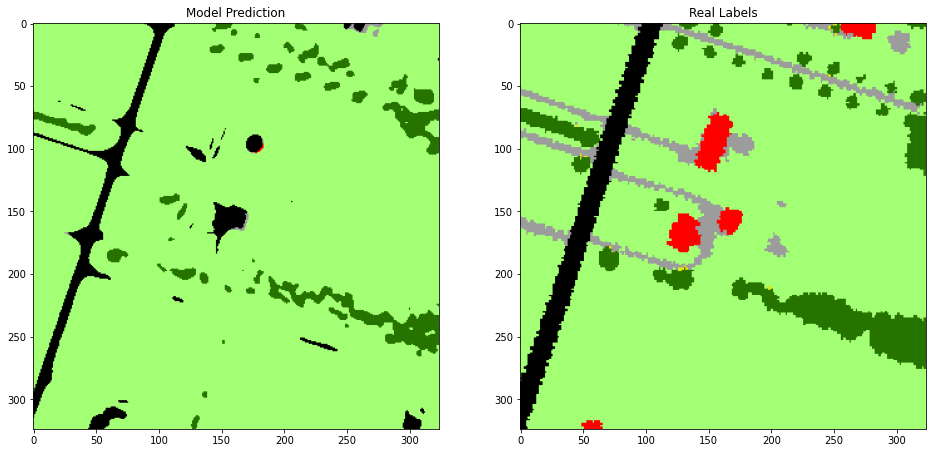

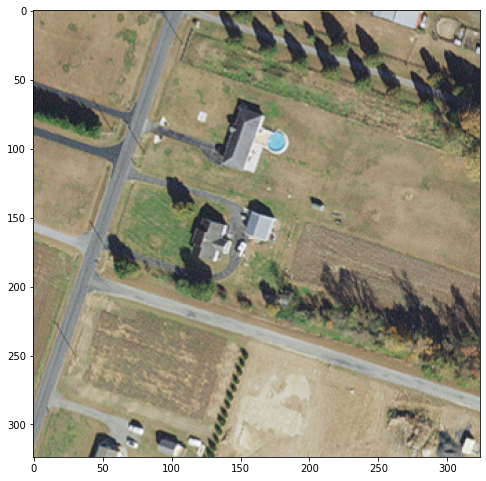

In [164]:
sample = next(iter(dataloader))
image, target = sample["image"], sample["mask"]
display_output(model, image, target)

Loss: tensor(0.3525, device='cuda:0')


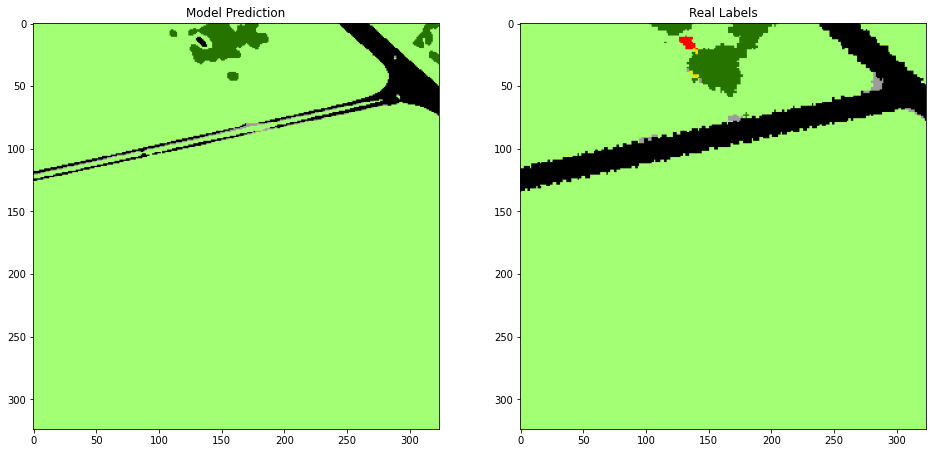

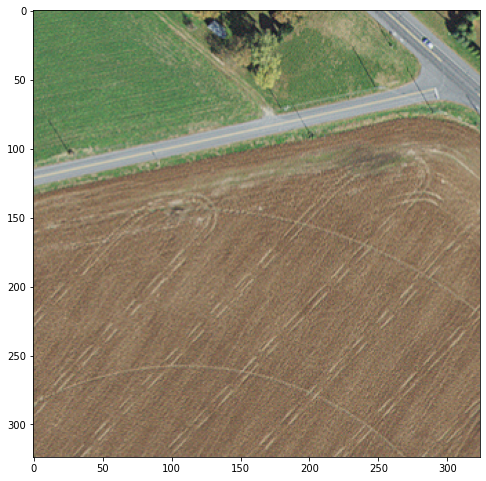

In [176]:
sample = next(iter(dataloader))
image, target = sample["image"], sample["mask"]
display_output(model, image, target)

In [ ]:
summary(model, input_size=[1, 4, 512, 512], col_names =['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
UNET                                          [1, 4, 512, 512]          [1, 14, 324, 324]         --                        True
├─DoubleConv: 1-1                             [1, 4, 512, 512]          [1, 64, 508, 508]         --                        True
│    └─Sequential: 2-1                        [1, 4, 512, 512]          [1, 64, 508, 508]         --                        True
│    │    └─Conv2d: 3-1                       [1, 4, 512, 512]          [1, 64, 510, 510]         2,368                     True
│    │    └─BatchNorm2d: 3-2                  [1, 64, 510, 510]         [1, 64, 510, 510]         128                       True
│    │    └─ReLU: 3-3                         [1, 64, 510, 510]         [1, 64, 510, 510]         --                        --
│    │    └─Conv2d: 3-4                       [1, 64, 510, 510]         [1, 64, 508, 508]     